In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


1.11.0+cu113
     |████████████████████████████████| 7.9 MB 46.6 MB/s 
     |████████████████████████████████| 3.5 MB 22.3 MB/s 


In [3]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 9.4 MB/s 
     |████████████████████████████████| 22.7 MB 1.4 MB/s 


In [4]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [5]:


data = pd.read_csv('raw/totalData.csv')

data.head() 

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1
1,1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl
2,2,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...
3,3,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1
4,4,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12


In [6]:

remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              print(count)
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

Processing...
  1%|          | 60/10951 [00:00<01:37, 111.21it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  1%|          | 72/10951 [00:00<01:43, 104.85it/s]Failed to featurize datapoint 0, [Gd+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


68
76


  1%|▏         | 139/10951 [00:01<02:37, 68.59it/s]Failed to featurize datapoint 0, [81Kr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|▏         | 163/10951 [00:02<02:16, 79.04it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


149
163


  3%|▎         | 348/10951 [00:04<01:41, 104.53it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  3%|▎         | 371/10951 [00:05<01:48, 97.42it/s] 

349


  4%|▍         | 422/10951 [00:05<01:54, 91.66it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  4%|▍         | 432/10951 [00:05<01:57, 89.70it/s]Failed to featurize datapoint 0, [Sb+5]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  4%|▍         | 442/10951 [00:05<01:56, 89.86it/s]

420
427


  5%|▍         | 494/10951 [00:06<01:51, 93.76it/s]Failed to featurize datapoint 0, [Cr+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|▍         | 515/10951 [00:06<01:51, 93.86it/s]

491


  5%|▌         | 595/10951 [00:07<01:50, 94.03it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  6%|▌         | 607/10951 [00:07<01:45, 97.87it/s]

590


  6%|▌         | 629/10951 [00:07<01:50, 93.39it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  6%|▌         | 649/10951 [00:08<01:53, 90.75it/s]

629


  8%|▊         | 921/10951 [00:13<04:40, 35.78it/s]Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  9%|▊         | 933/10951 [00:13<03:42, 45.11it/s]

911


  9%|▊         | 945/10951 [00:13<03:17, 50.59it/s]Failed to featurize datapoint 0, [13NH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▊         | 951/10951 [00:13<03:14, 51.53it/s]

934


  9%|▉         | 1017/10951 [00:15<03:31, 47.04it/s]Failed to featurize datapoint 0, [Zn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▉         | 1023/10951 [00:15<03:21, 49.32it/s]

1008


 11%|█         | 1215/10951 [00:19<03:29, 46.41it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 11%|█         | 1228/10951 [00:20<03:16, 49.60it/s]

1205


 11%|█▏        | 1236/10951 [00:20<02:50, 57.12it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 11%|█▏        | 1242/10951 [00:20<03:00, 53.90it/s]

1224


 12%|█▏        | 1283/10951 [00:21<03:40, 43.76it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 12%|█▏        | 1293/10951 [00:21<03:49, 42.02it/s]

1271


 12%|█▏        | 1317/10951 [00:22<04:10, 38.45it/s]Failed to featurize datapoint 0, [89Sr+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 12%|█▏        | 1330/10951 [00:22<03:23, 47.27it/s]

1304


 14%|█▍        | 1535/10951 [00:29<03:34, 43.83it/s]Failed to featurize datapoint 0, [3He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1541/10951 [00:29<04:07, 37.96it/s]

1518


 14%|█▍        | 1558/10951 [00:29<03:56, 39.69it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 14%|█▍        | 1569/10951 [00:30<03:32, 44.05it/s]

1545


Failed to featurize datapoint 0, [La+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1574/10951 [00:30<03:56, 39.66it/s]Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1579/10951 [00:30<04:32, 34.36it/s]

1554
1554


 15%|█▌        | 1673/10951 [00:35<11:29, 13.45it/s]Failed to featurize datapoint 0, [Co]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 15%|█▌        | 1685/10951 [00:35<06:55, 22.32it/s]

1656


 17%|█▋        | 1832/10951 [00:37<01:57, 77.49it/s]Failed to featurize datapoint 0, O.O.O.O.[98Tc-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 17%|█▋        | 1851/10951 [00:38<01:48, 83.62it/s]

1811


 18%|█▊        | 1932/10951 [00:39<01:53, 79.21it/s]Failed to featurize datapoint 0, [Na+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 18%|█▊        | 1941/10951 [00:39<02:11, 68.48it/s]

1913


 18%|█▊        | 1959/10951 [00:39<01:57, 76.48it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 18%|█▊        | 1980/10951 [00:39<01:43, 86.77it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


1942
1961


 20%|█▉        | 2142/10951 [00:41<01:36, 91.41it/s] Failed to featurize datapoint 0, O. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 20%|█▉        | 2155/10951 [00:41<01:28, 99.29it/s]

2116


 24%|██▍       | 2662/10951 [00:46<01:21, 101.68it/s]Failed to featurize datapoint 0, [89Sr+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 25%|██▍       | 2684/10951 [00:47<01:24, 97.80it/s] 

2643


 26%|██▌       | 2815/10951 [00:48<01:21, 100.20it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [Pt]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2836/10951 [00:48<01:23, 96.86it/s]

2788
2795


Failed to featurize datapoint 0, [223Ra+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2846/10951 [00:48<01:24, 95.56it/s]Failed to featurize datapoint 0, [67Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2859/10951 [00:48<01:24, 95.63it/s]

2811
2815


 26%|██▌       | 2869/10951 [00:49<01:29, 90.67it/s]Failed to featurize datapoint 0, [Ne]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▋       | 2882/10951 [00:49<01:21, 99.37it/s]

2848


 29%|██▊       | 3138/10951 [00:52<01:32, 84.78it/s]Failed to featurize datapoint 0, [32PH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 29%|██▉       | 3152/10951 [00:52<01:19, 97.67it/s]Failed to featurize datapoint 0, [K+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 29%|██▉       | 3165/10951 [00:52<01:14, 103.98it/s]

3111
3128


 30%|██▉       | 3247/10951 [00:53<01:11, 107.50it/s]Failed to featurize datapoint 0, [Ac]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3258/10951 [00:53<01:12, 105.61it/s]Failed to featurize datapoint 0, F. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3271/10951 [00:53<01:09, 110.54it/s]

3212
3222


 30%|███       | 3294/10951 [00:53<01:15, 100.96it/s]Failed to featurize datapoint 0, [Al+3].[Al+3].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 30%|███       | 3305/10951 [00:53<01:29, 85.06it/s] 

3258


 30%|███       | 3315/10951 [00:53<01:26, 88.17it/s]Failed to featurize datapoint 0, [Cl-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|███       | 3327/10951 [00:53<01:20, 94.76it/s]

3283


 32%|███▏      | 3476/10951 [00:55<01:19, 94.16it/s]Failed to featurize datapoint 0, [Ag+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 32%|███▏      | 3496/10951 [00:55<01:33, 79.84it/s]

3444


 33%|███▎      | 3577/10951 [00:56<01:24, 86.77it/s] Failed to featurize datapoint 0, [Ca+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 33%|███▎      | 3600/10951 [00:56<01:16, 95.93it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


3546
3563


 34%|███▍      | 3772/10951 [00:59<01:31, 78.71it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|███▍      | 3782/10951 [00:59<01:26, 82.80it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|███▍      | 3794/10951 [00:59<01:17, 91.94it/s]

3733
3741


 35%|███▍      | 3827/10951 [00:59<01:17, 92.27it/s]Failed to featurize datapoint 0, [Ta]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███▌      | 3837/10951 [01:00<01:17, 92.21it/s]Failed to featurize datapoint 0, [Bk]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███▌      | 3849/10951 [01:00<01:12, 98.58it/s]

3787
3802


 36%|███▋      | 3980/10951 [01:01<01:13, 95.08it/s]Failed to featurize datapoint 0, [Li+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 37%|███▋      | 4000/10951 [01:01<01:20, 85.96it/s]

3940


 37%|███▋      | 4045/10951 [01:02<02:32, 45.34it/s] Failed to featurize datapoint 0, [Ti]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4061/10951 [01:02<02:09, 53.00it/s]

4000


Failed to featurize datapoint 0, [Co+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4080/10951 [01:03<01:40, 68.15it/s]

4015


 38%|███▊      | 4152/10951 [01:03<01:19, 85.28it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 38%|███▊      | 4173/10951 [01:04<01:20, 84.14it/s]

4108


 38%|███▊      | 4182/10951 [01:04<01:22, 82.34it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Cl-].[Cr+3]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 38%|███▊      | 4202/10951 [01:04<01:14, 90.88it/s]

4138


 39%|███▉      | 4253/10951 [01:05<01:14, 90.31it/s]Failed to featurize datapoint 0, [99Tc]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 39%|███▉      | 4263/10951 [01:05<01:22, 80.84it/s]

4206


 41%|████      | 4447/10951 [01:08<02:08, 50.55it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████      | 4462/10951 [01:08<01:45, 61.22it/s]

4395


 41%|████      | 4504/10951 [01:09<01:38, 65.43it/s]Failed to featurize datapoint 0, [Ba]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Mo]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████▏     | 4522/10951 [01:09<01:28, 72.80it/s]

4452
4453


 43%|████▎     | 4726/10951 [01:11<01:26, 71.55it/s]Failed to featurize datapoint 0, [Cd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


4676


 43%|████▎     | 4749/10951 [01:12<01:53, 54.49it/s]Failed to featurize datapoint 0, [123I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 44%|████▎     | 4773/10951 [01:12<01:22, 74.72it/s]

4703


 45%|████▌     | 4953/10951 [01:14<01:11, 83.78it/s]Failed to featurize datapoint 0, [P]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 45%|████▌     | 4975/10951 [01:14<01:05, 91.63it/s]

4899


 46%|████▌     | 5018/10951 [01:15<01:06, 89.74it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▌     | 5041/10951 [01:15<00:58, 101.12it/s]

4962


 46%|████▌     | 5052/10951 [01:15<01:08, 85.75it/s] Failed to featurize datapoint 0, [OH-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▋     | 5077/10951 [01:15<00:56, 104.11it/s]

4994


 47%|████▋     | 5193/10951 [01:17<01:04, 88.64it/s]Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5214/10951 [01:17<01:04, 89.30it/s]

5143


 48%|████▊     | 5261/10951 [01:18<01:07, 84.43it/s]Failed to featurize datapoint 0, [I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5283/10951 [01:18<01:00, 93.31it/s]

5201


 49%|████▉     | 5353/10951 [01:18<00:53, 104.78it/s]Failed to featurize datapoint 0, [Cl-].[Tl+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 49%|████▉     | 5375/10951 [01:19<00:56, 99.22it/s]Failed to featurize datapoint 0, [18F]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


5296
5312


 50%|████▉     | 5444/10951 [01:19<00:54, 100.62it/s]Failed to featurize datapoint 0, [V]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|████▉     | 5466/10951 [01:19<00:53, 102.74it/s]

5385


Failed to featurize datapoint 0, [82Rb+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|█████     | 5487/10951 [01:20<01:07, 80.76it/s]

5406


 51%|█████     | 5548/10951 [01:21<01:07, 80.04it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 51%|█████     | 5558/10951 [01:21<01:03, 84.67it/s]Failed to featurize datapoint 0, [51Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5571/10951 [01:21<00:57, 93.91it/s]

5487
5491


 51%|█████     | 5582/10951 [01:21<00:55, 96.79it/s]Failed to featurize datapoint 0, [Sb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5596/10951 [01:21<00:50, 105.20it/s]Failed to featurize datapoint 0, [177Lu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5610/10951 [01:21<00:47, 111.95it/s]

5526
5533


 52%|█████▏    | 5667/10951 [01:22<00:50, 104.09it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5688/10951 [01:22<01:01, 85.55it/s]

5604


 52%|█████▏    | 5710/10951 [01:22<00:54, 95.89it/s]Failed to featurize datapoint 0, [Rb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5733/10951 [01:22<00:50, 103.83it/s]

5640


 53%|█████▎    | 5791/10951 [01:23<00:48, 106.85it/s]Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 53%|█████▎    | 5814/10951 [01:23<00:47, 108.14it/s]

5729


 56%|█████▋    | 6183/10951 [01:30<01:16, 62.54it/s]Failed to featurize datapoint 0, [Fe+3].[O-2].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 57%|█████▋    | 6208/10951 [01:30<00:57, 82.77it/s]

6112


 59%|█████▉    | 6490/10951 [01:36<01:16, 58.65it/s]Failed to featurize datapoint 0, [90Y]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 59%|█████▉    | 6508/10951 [01:37<01:09, 64.01it/s]

6422


 60%|█████▉    | 6546/10951 [01:37<01:03, 68.94it/s]Failed to featurize datapoint 0, O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 60%|█████▉    | 6565/10951 [01:37<00:57, 76.63it/s]

6479


 60%|██████    | 6575/10951 [01:37<00:53, 81.87it/s]Failed to featurize datapoint 0, [153Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 60%|██████    | 6594/10951 [01:38<00:52, 83.59it/s]

6502


 62%|██████▏   | 6779/10951 [01:41<00:37, 110.04it/s]Failed to featurize datapoint 0, [Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 62%|██████▏   | 6791/10951 [01:41<00:39, 105.44it/s]Failed to featurize datapoint 0, [Na+].[Na+].[S-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


6707
6717


 63%|██████▎   | 6850/10951 [01:42<01:02, 66.00it/s]Failed to featurize datapoint 0, [201Tl+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 63%|██████▎   | 6860/10951 [01:42<00:56, 72.57it/s]

6776


 65%|██████▌   | 7126/10951 [01:47<00:56, 67.21it/s]Failed to featurize datapoint 0, [B]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 65%|██████▌   | 7143/10951 [01:47<00:52, 71.93it/s]

7050


 65%|██████▌   | 7156/10951 [01:47<00:44, 85.63it/s]Failed to featurize datapoint 0, O.[Al+3].[Al+3].[Cl-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 66%|██████▌   | 7176/10951 [01:47<00:43, 87.46it/s]

7079


 67%|██████▋   | 7303/10951 [01:49<00:39, 92.75it/s]Failed to featurize datapoint 0, [Mg+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 67%|██████▋   | 7326/10951 [01:49<00:37, 95.89it/s]

7229


 67%|██████▋   | 7336/10951 [01:49<00:41, 86.40it/s]Failed to featurize datapoint 0, Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.[Br-].[Ta+].[Ta].[Ta].[Ta].[Ta].[Ta]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 67%|██████▋   | 7357/10951 [01:49<00:45, 79.83it/s]

7261


 68%|██████▊   | 7412/10951 [01:50<00:39, 88.99it/s]Failed to featurize datapoint 0, [Fe+2].[Fe+3].[Fe+3].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7433/10951 [01:50<00:38, 91.57it/s]

7329


 68%|██████▊   | 7453/10951 [01:50<00:40, 86.77it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7463/10951 [01:50<00:39, 89.39it/s]

7370


 69%|██████▊   | 7513/10951 [01:55<04:12, 13.64it/s]Failed to featurize datapoint 0, [Al]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7535/10951 [01:55<02:14, 25.31it/s]

7432


 69%|██████▉   | 7544/10951 [01:56<01:51, 30.69it/s]Failed to featurize datapoint 0, [Mn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7566/10951 [01:56<01:07, 49.80it/s]

7466


 69%|██████▉   | 7586/10951 [01:56<00:51, 65.44it/s]Failed to featurize datapoint 0, [223Ra]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7596/10951 [01:56<00:46, 71.64it/s]

7507


 71%|███████   | 7726/10951 [01:58<00:39, 81.80it/s]Failed to featurize datapoint 0, [I-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 71%|███████   | 7746/10951 [01:58<00:36, 87.44it/s]

7646


 72%|███████▏  | 7846/10951 [02:00<00:47, 64.86it/s]Failed to featurize datapoint 0, [Ag]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 72%|███████▏  | 7868/10951 [02:00<00:40, 76.96it/s]

7758


 76%|███████▌  | 8275/10951 [02:05<00:35, 75.24it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▌  | 8285/10951 [02:05<00:34, 76.43it/s]

8184


 76%|███████▌  | 8335/10951 [02:06<00:32, 80.68it/s]Failed to featurize datapoint 0, [Si]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▋  | 8356/10951 [02:06<00:28, 89.81it/s]

8251


 76%|███████▋  | 8377/10951 [02:06<00:28, 91.81it/s]Failed to featurize datapoint 0, O.O.O.O.[Al+3].[Mg+2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[OH-].[Si+4].[Si+4].[Si+4].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 77%|███████▋  | 8397/10951 [02:07<00:30, 84.14it/s]

8289


 77%|███████▋  | 8448/10951 [02:07<00:27, 91.07it/s]Failed to featurize datapoint 0, [Bi+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 77%|███████▋  | 8469/10951 [02:07<00:28, 86.49it/s]

8357


Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8494/10951 [02:08<00:23, 103.33it/s]

8383


 78%|███████▊  | 8542/10951 [02:08<00:23, 104.28it/s]Failed to featurize datapoint 0, [F-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8563/10951 [02:08<00:30, 78.79it/s]

8456


 79%|███████▊  | 8608/10951 [02:09<00:23, 101.16it/s]Failed to featurize datapoint 0, [F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 79%|███████▉  | 8632/10951 [02:09<00:21, 108.53it/s]

8520


 80%|████████  | 8783/10951 [02:11<00:27, 79.42it/s]Failed to featurize datapoint 0, [KH]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 80%|████████  | 8805/10951 [02:11<00:23, 91.26it/s]

8687


 83%|████████▎ | 9045/10951 [02:14<00:21, 88.78it/s]Failed to featurize datapoint 0, [Cu+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 83%|████████▎ | 9066/10951 [02:14<00:19, 94.90it/s]

8954


 83%|████████▎ | 9101/10951 [02:14<00:17, 105.13it/s]Failed to featurize datapoint 0, [Al+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 83%|████████▎ | 9112/10951 [02:14<00:18, 101.85it/s]

9001


 84%|████████▍ | 9173/10951 [02:15<00:20, 86.37it/s]Failed to featurize datapoint 0, [Cu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 84%|████████▍ | 9182/10951 [02:15<00:21, 82.59it/s]Failed to featurize datapoint 0, [MgH2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


9073
9087


 86%|████████▌ | 9393/10951 [02:17<00:14, 108.30it/s]Failed to featurize datapoint 0, [Fe+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 86%|████████▌ | 9415/10951 [02:18<00:14, 104.29it/s]

9293


 87%|████████▋ | 9493/10951 [02:19<00:17, 82.06it/s]Failed to featurize datapoint 0, [Cu+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|████████▋ | 9517/10951 [02:19<00:14, 96.32it/s]

9399


 87%|████████▋ | 9541/10951 [02:19<00:15, 93.46it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 87%|████████▋ | 9553/10951 [02:19<00:14, 99.03it/s]Failed to featurize datapoint 0, [Nb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|████████▋ | 9564/10951 [02:19<00:14, 97.54it/s]

9436
9454


 88%|████████▊ | 9586/10951 [02:20<00:13, 98.54it/s]Failed to featurize datapoint 0, [Au]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9609/10951 [02:20<00:13, 101.90it/s]

9485


 88%|████████▊ | 9641/10951 [02:20<00:14, 88.35it/s]Failed to featurize datapoint 0, [133Xe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9666/10951 [02:20<00:12, 105.27it/s]

9541


 89%|████████▉ | 9778/10951 [02:22<00:14, 78.27it/s] Failed to featurize datapoint 0, [Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 89%|████████▉ | 9787/10951 [02:22<00:14, 80.92it/s]

9669


 90%|████████▉ | 9816/10951 [02:22<00:13, 84.60it/s]Failed to featurize datapoint 0, [Na+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 90%|████████▉ | 9837/10951 [02:22<00:12, 86.45it/s]

9709


 91%|█████████ | 9961/10951 [02:24<00:11, 89.05it/s] Failed to featurize datapoint 0, [He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 91%|█████████ | 9971/10951 [02:24<00:11, 83.06it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 91%|█████████ | 9982/10951 [02:24<00:10, 88.84it/s]

9857
9864
9866


 93%|█████████▎| 10146/10951 [02:26<00:08, 93.07it/s]Failed to featurize datapoint 0, [Fe+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10167/10951 [02:26<00:08, 93.64it/s]

10038


 93%|█████████▎| 10190/10951 [02:26<00:07, 100.26it/s]Failed to featurize datapoint 0, [111In+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [67Ga+3].[Cl-].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 93%|█████████▎| 10203/10951 [02:26<00:06, 108.34it/s]

10077
10082


 93%|█████████▎| 10215/10951 [02:26<00:08, 81.94it/s] Failed to featurize datapoint 0, [Ni+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10236/10951 [02:27<00:08, 88.92it/s]

10101
10103


 94%|█████████▎| 10246/10951 [02:27<00:08, 87.47it/s]Failed to featurize datapoint 0, [Ca]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|█████████▍| 10268/10951 [02:27<00:07, 85.85it/s]

10138


Failed to featurize datapoint 0, [K+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|█████████▍| 10288/10951 [02:27<00:07, 86.67it/s]

10154


 95%|█████████▌| 10410/10951 [02:29<00:08, 65.46it/s]Failed to featurize datapoint 0, [Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 95%|█████████▌| 10429/10951 [02:29<00:06, 77.92it/s]

10295


 95%|█████████▌| 10450/10951 [02:29<00:08, 58.48it/s]Failed to featurize datapoint 0, [Gd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 96%|█████████▌| 10470/10951 [02:30<00:06, 72.85it/s]

10328


 96%|█████████▌| 10492/10951 [02:30<00:05, 87.63it/s]Failed to featurize datapoint 0, O.O.O.O.[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|█████████▌| 10502/10951 [02:30<00:05, 88.93it/s]Failed to featurize datapoint 0, [Mg+2].[O-2].[O-2].[O-2].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|█████████▌| 10512/10951 [02:30<00:04, 88.29it/s]

10370
10383


 97%|█████████▋| 10650/10951 [02:32<00:03, 82.35it/s]Failed to featurize datapoint 0, [18F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 97%|█████████▋| 10675/10951 [02:32<00:02, 100.79it/s]

10529


 98%|█████████▊| 10753/10951 [02:33<00:02, 78.14it/s]Failed to featurize datapoint 0, [Au+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 98%|█████████▊| 10767/10951 [02:33<00:02, 86.15it/s]

10627


 99%|█████████▉| 10838/10951 [02:34<00:01, 88.17it/s]Failed to featurize datapoint 0, [In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 99%|█████████▉| 10849/10951 [02:34<00:01, 66.09it/s]

10718


100%|█████████▉| 10897/10951 [02:34<00:00, 92.54it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sr+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|█████████▉| 10908/10951 [02:34<00:00, 94.00it/s]Failed to featurize datapoint 0, [111In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10778
10782


100%|█████████▉| 10918/10951 [02:35<00:00, 74.26it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|█████████▉| 10930/10951 [02:35<00:00, 83.56it/s]

10789


100%|██████████| 10951/10951 [02:36<00:00, 70.06it/s]
Done!


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
class GVAE(nn.Module):
    def __init__(self, feature_size, edge_size):
        super(GVAE, self).__init__()
        self.encoder_embedding_size = 64
        self.edge_dim = edge_size
        self.latent_embedding_size = 8
        self.decoder_hidden_neurons = 64
        decoder_size = 64

        # Encoder layers
        self.conv1 = GCNConv(feature_size, self.encoder_embedding_size)
        #self.conv1 = GATConv(feature_size, self.encoder_embedding_size,edge_dim=self.edge_dim)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn3 = BatchNorm(self.encoder_embedding_size)
        

        # Latent transform layers
        self.mu_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)
        self.logvar_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)

        

        self.decoder_dense_3 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, 1)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index).relu()
        # x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x)
        logvar = self.logvar_transform(x)
        return mu, logvar


    def decode(self, z, batch_index):
        """
        Takes n latent vectors (one per node) and decodes them
        into the upper triangular part of their adjacency matrix.
        """
        inputs = []

        # Iterate over molecules in batch
        for graph_id in torch.unique(batch_index):
            graph_mask = torch.eq(batch_index, graph_id)
            graph_z = z[graph_mask]

            # Get indices for triangular upper part of adjacency matrix
            edge_indices = torch.triu_indices(graph_z.shape[0], graph_z.shape[0], offset=1)

            # Repeat indices to match dim of latent codes
            dim = self.latent_embedding_size
            source_indices = torch.reshape(edge_indices[0].repeat_interleave(dim), (edge_indices.shape[1], dim))
            target_indices = torch.reshape(edge_indices[1].repeat_interleave(dim), (edge_indices.shape[1], dim))

            # Gather features
            sources_feats = torch.gather(graph_z, 0, source_indices.to(device))
            target_feats = torch.gather(graph_z, 0, target_indices.to(device))

            # Concatenate inputs of all source and target nodes
            graph_inputs = torch.cat([sources_feats, target_feats], axis=1)
            inputs.append(graph_inputs)

        # Concatenate all inputs of all graphs in the batch
        inputs = torch.cat(inputs)

       
        x = self.decoder_dense_3(inputs).relu()
        x = self.decoder_bn_3(x)
        edge_logits = self.decoder_dense_4(x)
   

        return edge_logits


    def reparameterize(self, mu, logvar):
        """
        The reparametrization trick is required to 
        backpropagate through the network.
        We cannot backpropagate through a "sampled"
        node as it is not deterministic.
        The trick is to separate the randomness
        from the network.
        """
        if self.training:
            # Get standard deviation
            std = torch.exp(logvar)
            # Returns random numbers from a normal distribution
            eps = torch.randn_like(std)
            # Return sampled values
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Encode the molecule
        mu, logvar = self.encode(x, edge_attr, edge_index, batch_index)
        # Sample latent vector (per atom)
        z = self.reparameterize(mu, logvar)
        # Decode latent vector into original molecule
        triu_logits = self.decode(z, batch_index)

        return triu_logits, mu, logvar

    
   
model = GVAE(feature_size=encoder_set[0].x.shape[1],edge_size=encoder_set[0].edge_attr.shape[1])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GCNConv(30, 64)
  (bn1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm(64)
  (conv3): GCNConv(64, 64)
  (bn3): BatchNorm(64)
  (mu_transform): Linear(in_features=64, out_features=8, bias=True)
  (logvar_transform): Linear(in_features=64, out_features=8, bias=True)
  (decoder_dense_3): Linear(in_features=16, out_features=64, bias=True)
  (decoder_bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  13009


In [9]:
from torch_geometric.data import DataLoader

data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.5
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


model = model.to(device)


In [10]:
from torch_geometric.utils import to_dense_adj




def kl_loss(mu=None, logstd=None):
    """
    Closed formula of the KL divergence for normal distributions
    """
    MAX_LOGSTD = 10
    logstd =  logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div

def slice_graph_targets(graph_id, batch_targets, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    # Row slice and column slice batch targets to get graph targets
    graph_targets = batch_targets[graph_mask][:, graph_mask]
    # Get triangular upper part of adjacency matrix for targets
    triu_indices = torch.triu_indices(graph_targets.shape[0], graph_targets.shape[0], offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    return graph_targets[triu_mask]

def slice_graph_predictions(triu_logits, graph_triu_size, start_point):

    graph_logits_triu = torch.squeeze(triu_logits[start_point:start_point + graph_triu_size])  
    return graph_logits_triu

def slice_node_features(graph_id, node_features, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    graph_node_features = node_features[graph_mask]
    return graph_node_features

  

def gvae_loss(triu_logits, edge_index, mu, logvar, batch_index, kl_beta):
    """
    Calculates a weighted ELBO loss for a batch of graphs for the graph
    variational autoencoder model.
    """
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))

    # Reconstruction loss per graph
    batch_recon_loss = []
    batch_node_counter = 0

    # Loop over graphs in this batch
    for graph_id in torch.unique(batch_index):
        # Get upper triangular targets for this graph from the whole batch
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)

        # Get upper triangular predictions for this graph from the whole batch
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)
        
        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Calculate edge-weighted binary cross entropy
        weight = graph_targets_triu.shape[0]/sum(graph_targets_triu)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=weight).to(device)
        graph_recon_loss = bce(graph_predictions_triu.view(-1), graph_targets_triu.view(-1))
        batch_recon_loss.append(graph_recon_loss)   

    # Take average of all losses
    num_graphs = torch.unique(batch_index).shape[0]
    batch_recon_loss = sum(batch_recon_loss) / num_graphs
    
    # KL Divergence
    kl_divergence = kl_loss(mu, logvar)

    return batch_recon_loss + kl_beta * kl_divergence, kl_divergence


def reconstruction_accuracy(triu_logits, edge_index, batch_index, node_features):
    # Convert edge index to adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    # Store target trius
    batch_targets_triu = []
    # Iterate over batch and collect each of the trius
    batch_node_counter = 0
    num_recon = 0
    for graph_id in torch.unique(batch_index):
        # Get triu parts for this graph
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)

        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Slice node features of this batch
        graph_node_features = slice_node_features(graph_id, node_features, batch_index)

        # Check if graph is successfully reconstructed
        num_nodes = sum(torch.eq(batch_index, graph_id))
      
        batch_targets_triu.append(graph_targets_triu)
        
    batch_targets_triu = torch.cat(batch_targets_triu).detach()
    triu_discrete = torch.squeeze(torch.tensor(torch.sigmoid(triu_logits) > 0.5, dtype=torch.int32))
    acc = torch.true_divide(torch.sum(batch_targets_triu==triu_discrete), batch_targets_triu.shape[0]) 
    return acc.detach().cpu().numpy(), num_recon
    




In [11]:
loss_fn = gvae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
kl_beta = 0.005

In [12]:

def run_one_epoch(data_loader, type, epoch, kl_beta):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            triu_logits, mu, logvar = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            loss, kl_div = loss_fn(triu_logits, batch.edge_index, mu, logvar, batch.batch, kl_beta)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            # Calculate metrics
            acc = reconstruction_accuracy(triu_logits, batch.edge_index, batch.batch, batch.x.float())
            

            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
            all_accs.append(acc)
            
            

        except IndexError as error:
            # For a few graphs the edge information is not correct
            # Simply skip the batch containing those
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    print(f"{type} epoch {epoch} accuracy: ", np.array(all_accs).mean())
   

In [13]:
for epoch in range(6): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch, kl_beta=kl_beta)
  if epoch % 5 == 0:
      print("test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch, kl_beta=kl_beta)

100%|██████████| 85/85 [01:45<00:00,  1.24s/it]


Train epoch 0 loss:  1.4056449
Train epoch 0 accuracy:  0.24599918565329384
test epoch...


100%|██████████| 85/85 [01:50<00:00,  1.30s/it]


Test epoch 0 loss:  1.0121317
Test epoch 0 accuracy:  0.32222707552068375


100%|██████████| 85/85 [01:44<00:00,  1.23s/it]


Train epoch 1 loss:  0.9660538
Train epoch 1 accuracy:  0.33647181602085335


100%|██████████| 85/85 [01:44<00:00,  1.23s/it]


Train epoch 2 loss:  0.84112793
Train epoch 2 accuracy:  0.37101364416234633


 53%|█████▎    | 45/85 [00:57<00:45,  1.14s/it]

Error:  The shape of the mask [1545] at index 0 does not match the shape of the indexed tensor [1519, 1519] at index 0


100%|██████████| 85/85 [01:44<00:00,  1.22s/it]


Train epoch 3 loss:  0.7649626
Train epoch 3 accuracy:  0.38265809203897205


100%|██████████| 85/85 [01:44<00:00,  1.23s/it]


Train epoch 4 loss:  0.69675773
Train epoch 4 accuracy:  0.3984181516310748


100%|██████████| 85/85 [01:45<00:00,  1.24s/it]


Train epoch 5 loss:  0.64272225
Train epoch 5 accuracy:  0.40912997266825507
test epoch...


100%|██████████| 85/85 [01:49<00:00,  1.28s/it]

Test epoch 5 loss:  0.60226876
Test epoch 5 accuracy:  0.4102684013983783


In [14]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred, mu, logvar = model(batch.x.float(), 
                            batch.edge_attr.float(),
                            batch.edge_index, 
                            batch.batch) 
  
  
  dictval[batch.id[0]] = [mu,logvar]
  
print("done!!!")
  

      

done!!!


In [15]:
temp = pd.read_csv("sup_train_val.csv")
temp.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [16]:
df = temp

# df = pd.DataFrame(columns = ['Drug1_ID', 'Drug1_SMILES', 'Drug2_ID','Drug2_SMILES','label'])

# sz = len(temp)

# for i in range(sz):
#   id1 = temp['Drug1_ID'][i]
#   id2 = temp['Drug2_ID'][i]
#   if (id1 in dictval) and (id2 in dictval) : 
#     df = df.append({'Drug1_ID' : id1, 'Drug1_SMILES' : temp['Drug1_SMILES'][i], 'Drug2_ID' : id2,'Drug2_SMILES' : temp['Drug2_SMILES'][i],'label' : temp['label'][i]}, 
#                   ignore_index = True)

# df.head()

In [17]:
n_classes = len(df['label'].unique())
n_classes

2

In [18]:
df['label'].value_counts()

1.0    33243
0.0    33189
Name: label, dtype: int64

In [19]:
dftrain = df
dftest = pd.read_csv("sup_test.csv")


In [20]:
class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = dftrain
        # datat = datat.head(partition) 
        self.samples = list(range(2*len(datat)))
        self.label = list(range(2*len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            loop = 0
            if datat['label'][index]==0 :
              loop = 0
            elif datat['label'][index]==1 :
              loop = 0
            else :
              loop = 0

            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
            for genvar in range(0,loop) : 
              eps = torch.randn_like(dictval[str1][1])
              std = torch.exp(dictval[str1][1])
              mat1 = eps.mul(std).add_(dictval[str1][0])
              eps = torch.randn_like(dictval[str2][1])
              std = torch.exp(dictval[str2][1])
              mat2 = eps.mul(std).add_(dictval[str2][0])
              mean1 = torch.mean(mat1, axis = 0)
              std1 = torch.std(mat1, axis = 0)
              mean2 = torch.mean(mat2, axis = 0)
              std2 = torch.std(mat2, axis = 0)
              vect = torch.cat([mean1, mean2, std1, std2], dim=0)
              self.samples[idx] = vect.detach().cpu()
              self.label[idx] = datat['label'][index]
              self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
              idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset("sup_train_val.csv")
len(dataset)

65075

In [21]:
data = dataset
data[0][0].shape[0]

32

In [22]:
import torch.nn.functional as F 
torch.manual_seed(42)

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(data[0][0].shape[0],128)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  4482


In [23]:
# import torch.nn.functional as F 


# class NeuralNet(torch.nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(NeuralNet, self).__init__()
#         self.input_size = input_size
#         self.hidden_size  = hidden_size
#         self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
#         self.fc3 = torch.nn.Linear(self.hidden_size, n_classes)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x
# model_ff = NeuralNet(data[0][0].shape[0],64)
# print(model_ff)
# print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  

# Use GPU for training
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128
loader = DataLoader(data,batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      
      pred = model_ff(batch[0]) 
      
      # Calculating the loss and gradients
      
      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(251):
    loss = train(data)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 0.551418662071228
Epoch 50 | Train Loss 0.44408509135246277
Epoch 100 | Train Loss 0.39490392804145813
Epoch 150 | Train Loss 0.4024348556995392
Epoch 200 | Train Loss 0.3626149892807007
Epoch 250 | Train Loss 0.3567684292793274


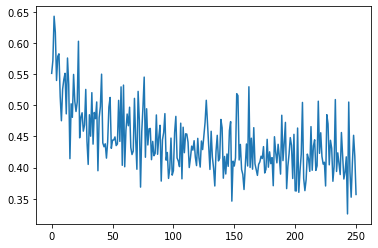

In [25]:

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [26]:
class TestDataset(Dataset):
    def __init__(self,filename):
        datat = dftest
        #datat = datat.tail(tailpp).reset_index(drop=True)
       
        self.samples = list(range(len(datat)))
        self.label = list(range(len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          
          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

datatest = TestDataset("sup_test.csv")
len(datatest)

16234

In [27]:
test_loader = DataLoader(datatest,batch_size=len(datatest), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = model_ff(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.8842322306988779


,y_real,y_pred,y_predfrac0,y_predfrac1
16229,1,1,0.020111,9.798891e-01
16230,0,0,0.999407,5.933484e-04
16231,0,0,1.000000,8.998990e-24
16232,1,1,0.149316,8.506839e-01
16233,0,0,0.999999,1.213913e-06


In [28]:
datahead = pd.read_csv('tt.csv')

print(f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print(f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print(accuracy_score(datahead['y_real'], datahead['y_pred']))

confusion_matrix(datahead['y_real'], datahead['y_pred'])

0.8842322306988779
0.8842552667241591
0.8842552667241592


array([[7292,  817],
       [1062, 7063]])

In [29]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,1.000000,5.777297e-13
1,0.999359,6.406304e-04
2,0.834512,1.654879e-01
3,1.000000,2.657393e-13
4,0.825088,1.749121e-01


In [30]:
probab = dfttt.to_numpy()

In [31]:
if n_classes==3 : 
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovo", average="macro")
  print(macro_roc_auc_ovo)
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovr", average="weighted")
  print(macro_roc_auc_ovo)
else : 
  auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
  print('AUC: %.3f' % auc)

AUC: 0.933


In [32]:
if n_classes == 3 : 
  Y_test = datahead['y_real']
  y_score = probab
  # Use label_binarize to be multi-label like settings
  Y = label_binarize(Y_test, classes=[0, 1, 2])
  n_classes = Y.shape[1]

  Y_test = Y


  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
  average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")
  print(average_precision["micro"])
  print(average_precision["macro"])

In [33]:
if n_classes == 3 :
  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot()
  _ = display.ax_.set_title("Micro-averaged over all classes")

Model: ROC AUC=0.933


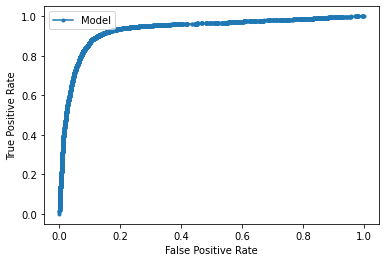

In [34]:

lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.883 auc=0.929


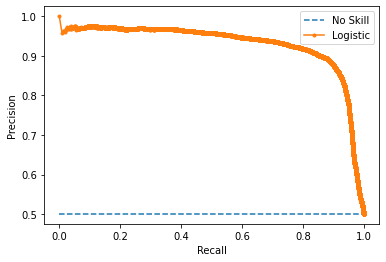

In [35]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [36]:


precision, recall, thresholds  = precision_recall_curve(datahead['y_real'], datahead['y_predfrac1'])
auc_score = metrics.auc(recall, precision)
auc_score

0.9292178448765405